In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.stats import mode
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
df = pd.read_csv('/content/drive/MyDrive/University/MemoireAbdelmalek/data/all/words.csv')
X = df[['flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5', 'GYRx', 'GYRy', 'GYRz', 'ACCx', 'ACCy', 'ACCz']].values
labels = df.iloc[:, -1]
label_dict = {label: i for i, label in enumerate(sorted(set(labels)))}
y = np.array([label_dict[label] for label in labels])
y = to_categorical(y, num_classes=len(label_dict))

print(label_dict)

print(X.shape, y.shape)
X = X.reshape((-1, 150, X.shape[1]))
y = y.reshape((-1, 150, y.shape[1]))
print(X.shape, y.shape)

{'bad': 0, 'deaf': 1, 'fine': 2, 'good': 3, 'goodbye': 4, 'hello': 5, 'hungry': 6, 'me': 7, 'no': 8, 'please': 9, 'sorry': 10, 'thankyou': 11, 'yes': 12, 'you': 13}
(525000, 11) (525000, 14)
(3500, 150, 11) (3500, 150, 14)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)

(2800, 150, 11) (700, 150, 11)


In [5]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

In [6]:
input_layer = Input(shape=(150, 11), name='input_layer')
lstm_layer = LSTM(units=38, return_sequences=True, name='lstm_layer')(input_layer)
output_layer = Dense(units=len(label_dict), activation='softmax', name='output_layer')(lstm_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [7]:
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_indices, val_indices) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold+1}")
    model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[checkpoint_callback])

Fold 1
Epoch 1/50
65/70 [==========================>...] - ETA: 0s - loss: 2.6240 - accuracy: 0.1076
Epoch 1: val_accuracy improved from -inf to 0.10001, saving model to best_model.h5
70/70 [==============================] - 8s 53ms/step - loss: 2.6209 - accuracy: 0.1093 - val_loss: 2.5848 - val_accuracy: 0.1000
Epoch 2/50
69/70 [============================>.] - ETA: 0s - loss: 2.5342 - accuracy: 0.1439
Epoch 2: val_accuracy improved from 0.10001 to 0.14308, saving model to best_model.h5
70/70 [==============================] - 2s 22ms/step - loss: 2.5332 - accuracy: 0.1446 - val_loss: 2.5054 - val_accuracy: 0.1431
Epoch 3/50
67/70 [===========================>..] - ETA: 0s - loss: 2.4545 - accuracy: 0.1828
Epoch 3: val_accuracy improved from 0.14308 to 0.19292, saving model to best_model.h5
70/70 [==============================] - 1s 16ms/step - loss: 2.4537 - accuracy: 0.1832 - val_loss: 2.4287 - val_accuracy: 0.1929
Epoch 4/50
68/70 [============================>.] - ETA: 0s - loss

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)

(2800, 150, 11) (700, 150, 11)


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=150, callbacks=[checkpoint_callback])

Epoch 1/150
64/70 [==========================>...] - ETA: 0s - loss: 0.1980 - accuracy: 0.9363
Epoch 1: val_accuracy improved from 0.90954 to 0.90969, saving model to best_model.h5
70/70 [==============================] - 1s 11ms/step - loss: 0.1959 - accuracy: 0.9370 - val_loss: 0.2580 - val_accuracy: 0.9097
Epoch 2/150
68/70 [============================>.] - ETA: 0s - loss: 0.1948 - accuracy: 0.9370
Epoch 2: val_accuracy improved from 0.90969 to 0.91076, saving model to best_model.h5
70/70 [==============================] - 1s 9ms/step - loss: 0.1942 - accuracy: 0.9376 - val_loss: 0.2551 - val_accuracy: 0.9108
Epoch 3/150
70/70 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 0.9379
Epoch 3: val_accuracy did not improve from 0.91076
70/70 [==============================] - 1s 9ms/step - loss: 0.1930 - accuracy: 0.9379 - val_loss: 0.2561 - val_accuracy: 0.9098
Epoch 4/150
70/70 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9377
Epoch 4: 

In [ ]:
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

22/22 [==============================] - 0s 4ms/step


In [ ]:
predictions = np.argmax(y_pred, axis=2)
print(predictions)
major = np.squeeze(mode(predictions)[0])
count = np.squeeze(mode(predictions)[1])
print(f"Predictions    : {major}")
print(f"Appeared times : {count}")

[[ 2  2  2 ...  2  2  2]
 [ 2 11 11 ... 11 11 11]
 [ 7  7  7 ...  7  7  7]
 ...
 [ 9  9  9 ...  9  9  9]
 [ 7 13 13 ... 13 13 13]
 [ 3  3  0 ...  0  0  0]]
Predictions    : [1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Appeared times : [79 73 69 65 64 63 63 63 63 63 63 64 63 64 63 64 64 64 64 64 63 63 64 64
 64 63 63 63 63 64 64 63 63 64 63 63 64 63 63 63 62 62 63 62 61 63 62 62
 63 63 62 62 63 63 62 62 63 63 63 63 62 62 61 61 62 61 61 61 61 61 61 61
 60 59 59 59 59 60 60 60 60 60 60 60 60 60 60 60 60 61 60 61 60 60 60 60
 60 60 60 60 60 60 60 60 60 60 61 61 61 60 60 60 60 60 60 60 60 60 61 61
 61 60 60 60 60 60 60 60 60 60 60 60 60 60 61 60 60 60 61 60 60 60 61 61
 60 60 60 60 60 60]


<ipython-input-11-f892e764b43a>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  major = np.squeeze(mode(predictions)[0])
<ipython-input-11-f892e764b43a>:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  count = np.squeeze(mode(predictions)[1])


In [ ]:
def get_key(dictionary, val):
    for key, value in dictionary.items():
        if val == value:
            return key

predictions_list = []
for word in major:
    predictions_list.append(get_key(label_dict, word))
print(predictions_list)

['deaf', 'good', 'good', 'good', 'good', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf', 'deaf',

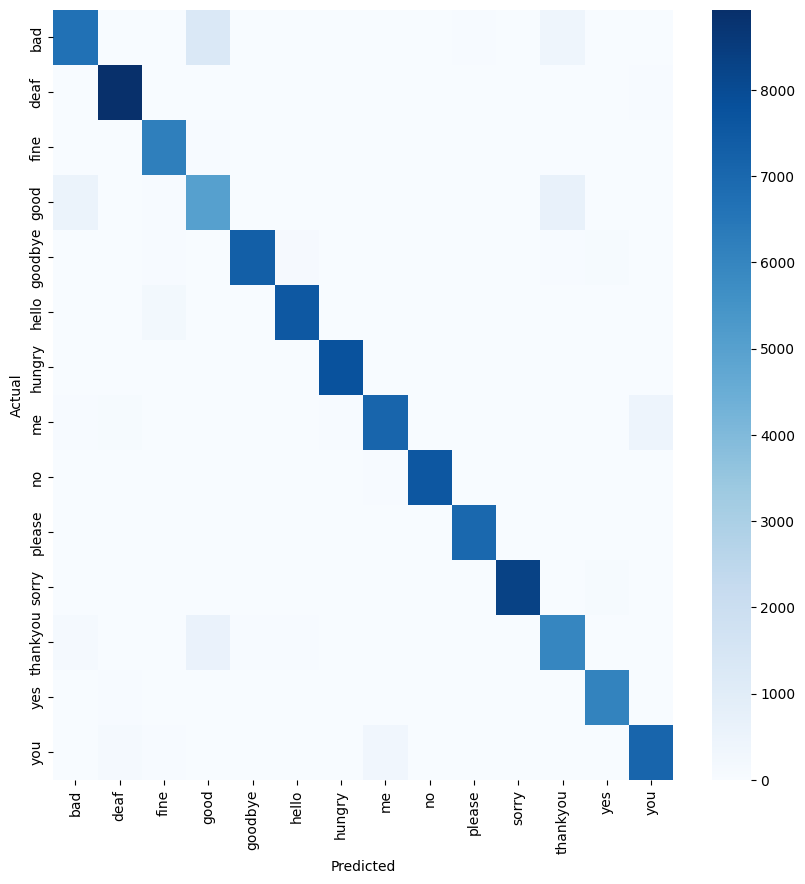

Accuracy: 93.92%


In [ ]:
cm = confusion_matrix(y_test.argmax(axis=2).flatten(), y_pred.argmax(axis=2).flatten())
plt.subplots(figsize=(10, 10))
sns.heatmap(cm, cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy: {accuracy*100:.2f}%")

In [ ]:
print(classification_report(y_test.argmax(axis=2).flatten(), y_pred.argmax(axis=2).flatten()))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      8550
           1       0.97      0.99      0.98      9000
           2       0.94      0.99      0.96      6300
           3       0.72      0.80      0.76      6300
           4       0.99      0.95      0.97      7650
           5       0.98      0.97      0.97      7800
           6       0.98      0.99      0.99      7800
           7       0.94      0.91      0.92      7800
           8       1.00      0.99      0.99      7650
           9       0.99      0.99      0.99      7050
          10       0.99      0.99      0.99      8400
          11       0.84      0.87      0.85      6900
          12       0.97      0.99      0.98      6150
          13       0.93      0.93      0.93      7650

    accuracy                           0.94    105000
   macro avg       0.94      0.94      0.94    105000
weighted avg       0.94      0.94      0.94    105000



In [ ]:
# model.save('/content/drive/MyDrive/University/MemoireAbdelmalek/models/words.h5')
model.save('words.h5')

In [ ]:
run_model = tf.function(lambda x: model(x))
BATCH_SIZE = 1
INPUT_SIZE = 150
STEPS = 11
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, INPUT_SIZE, STEPS], model.inputs[0].dtype))

MODEL_DIR = "./"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.allow_custom_ops = False
tflite_model = converter.convert()

In [ ]:
# with open('/content/drive/MyDrive/University/MemoireAbdelmalek/models/words.tflite', 'wb') as f:
#     f.write(tflite_model)
with open('words.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!xxd -i words.tflite > words.cc
# !xxd -i words.tflite drive/MyDrive/University/MemoireAbdelmalek/models/words.cc
!ls drive/MyDrive/University/MemoireAbdelmalek/models

characters.cc  characters.tflite  words.h5
characters.h5  words.cc		  words.tflite
